In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [2]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [4]:
data = pd.read_csv('/content/drive/MyDrive/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
data = data.sort_index()
print(data.index.is_monotonic)
data.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<ipython-input-5-2be2956d6cde>:2: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print(data.index.is_monotonic)


In [6]:
data['num_orders'].unique()

array([  9,  14,  28,  20,  32,  21,   7,   5,  17,  12,  19,  25,  22,
         8,   6,   4,  10,  13,   2,   3,   0,   1,  11,  15,  16,  23,
        18,  33,  24,  26,  30,  38,  34,  42,  31,  27,  36,  29,  35,
        56,  37,  40,  39,  45,  49,  58,  68,  43,  53,  44,  41,  52,
        46,  57,  47,  64,  61,  50,  48,  55,  62,  54,  71,  78, 119,
        99,  51,  60,  87,  90,  94,  82,  80,  91,  76,  66,  65,  98,
        81,  95,  67])

In [7]:
data['num_orders'].median()

13.0

In [8]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


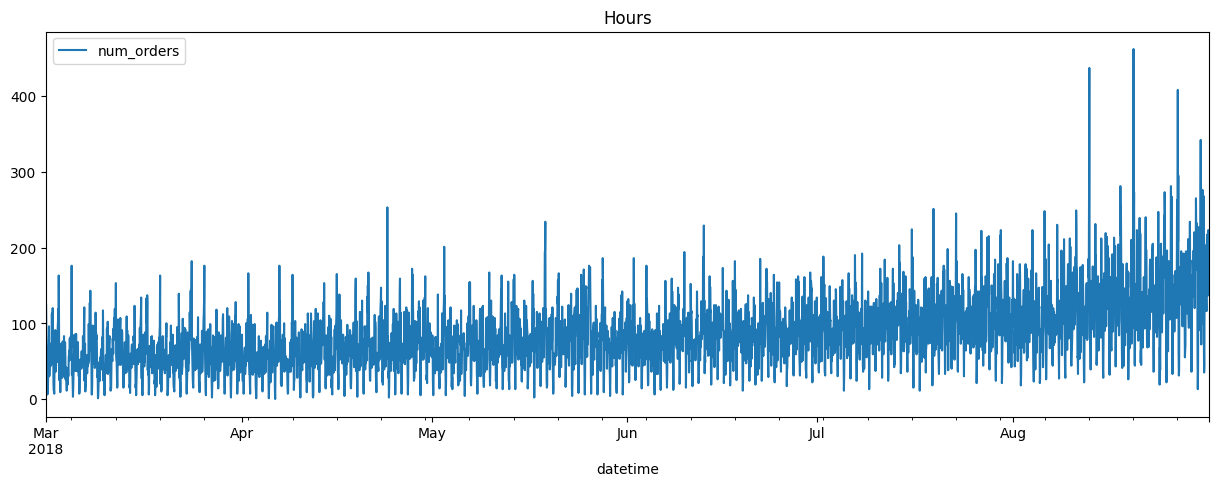

In [10]:
data_hour = data.resample('1H').sum()
data_hour.plot(figsize = (15, 5), title = ('Распределение по часам'));

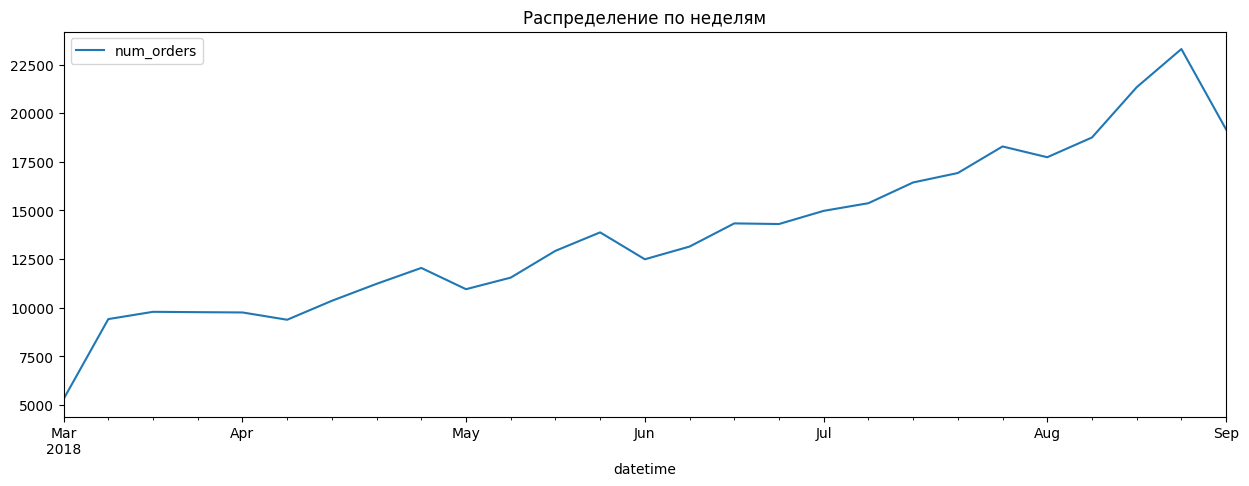

In [11]:
data_week = data.resample('1W').sum()
data_week.plot(figsize = (15 , 5), title = ('Распределение по неделям'));

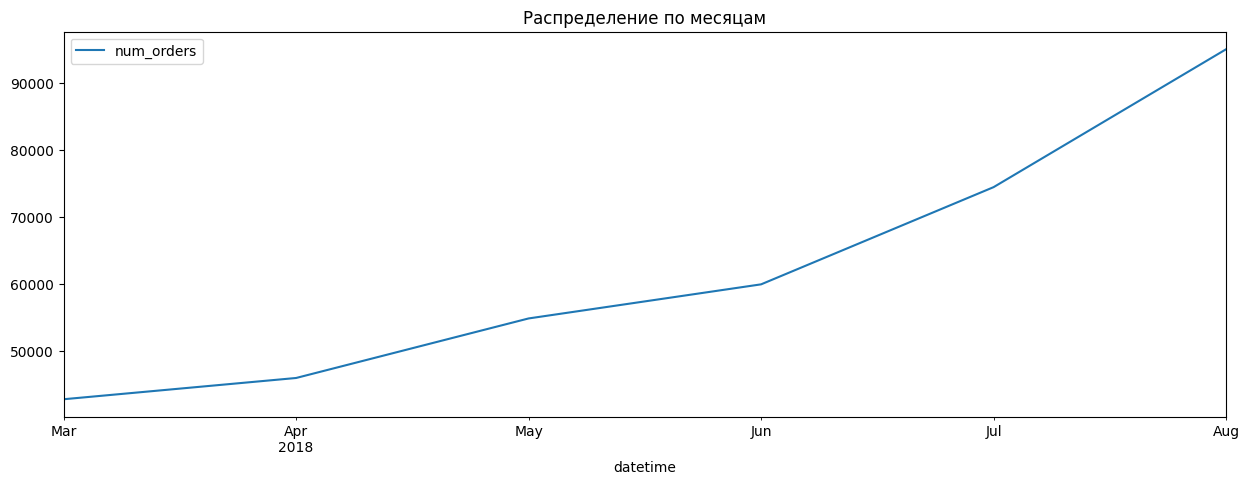

In [12]:
data_month = data.resample('1M').sum()
data_month.plot(figsize = (15 , 5), title = ('Распределение по месяцам'));

Видно что количество заказов постепенно растет, как вариант компания расширяется, больше клиентов и т.д, но заметен спад числа заказов к сентябрю


## Анализ

In [15]:
decomposed = seasonal_decompose(data_hour)
decomposed.seasonal.plot(figsize = (15 , 5), title = ('Сезонность'));

ValueError: ignored

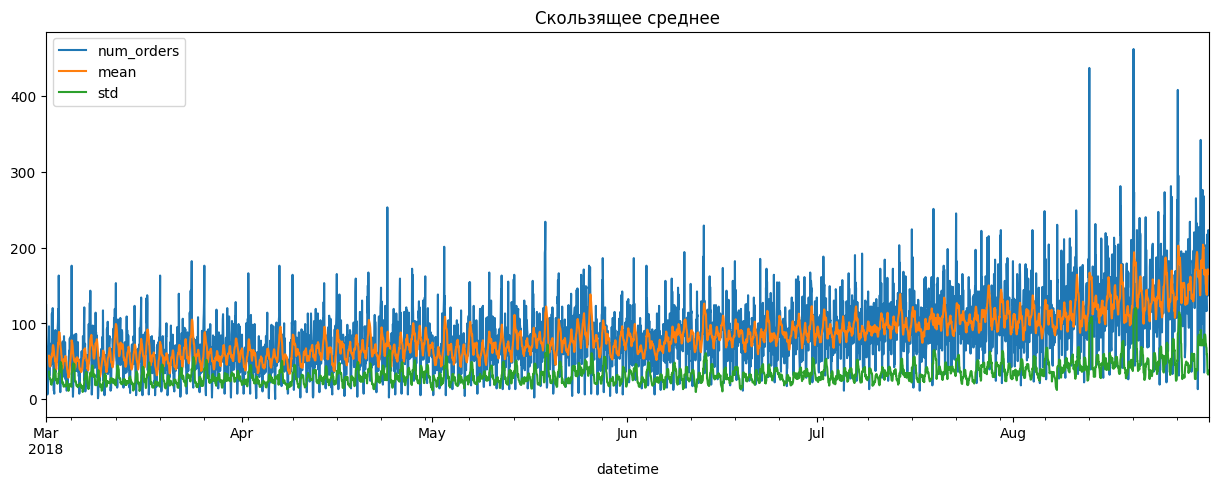

In [16]:
data_hour['mean'] = data_hour['num_orders'].rolling(12).mean()
data_hour['std'] = data_hour['num_orders'].rolling(12).std()
data_hour.plot(figsize = (15 , 5), title = ('Скользящее среднее'));

К концу ряд становится нестационарным, позже проверим его на разности

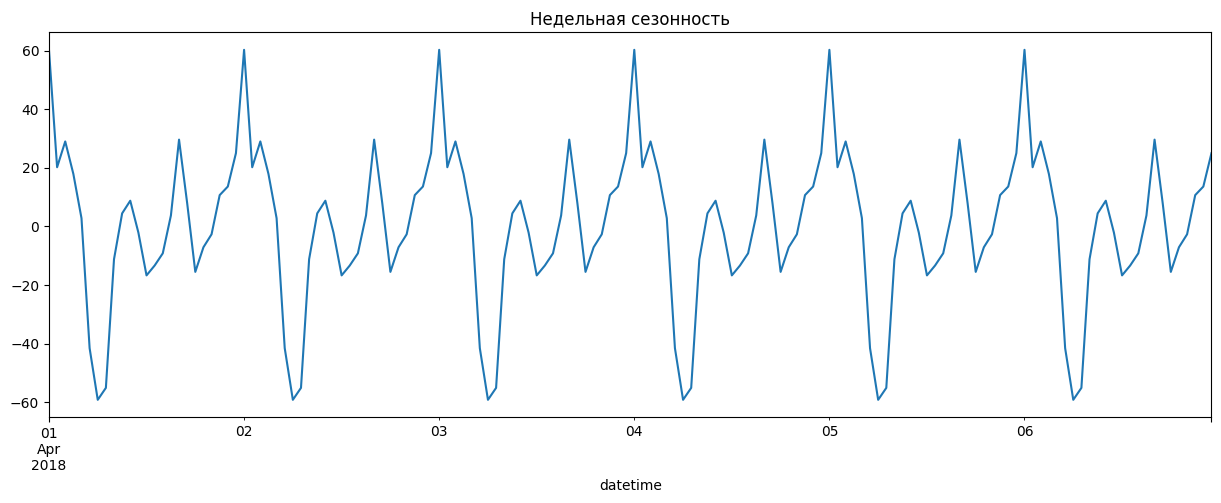

In [18]:
decomposed.seasonal['2018-04-01':'2018-04-06'].plot(figsize = (15 , 5), title = ('Недельная сезонность'));

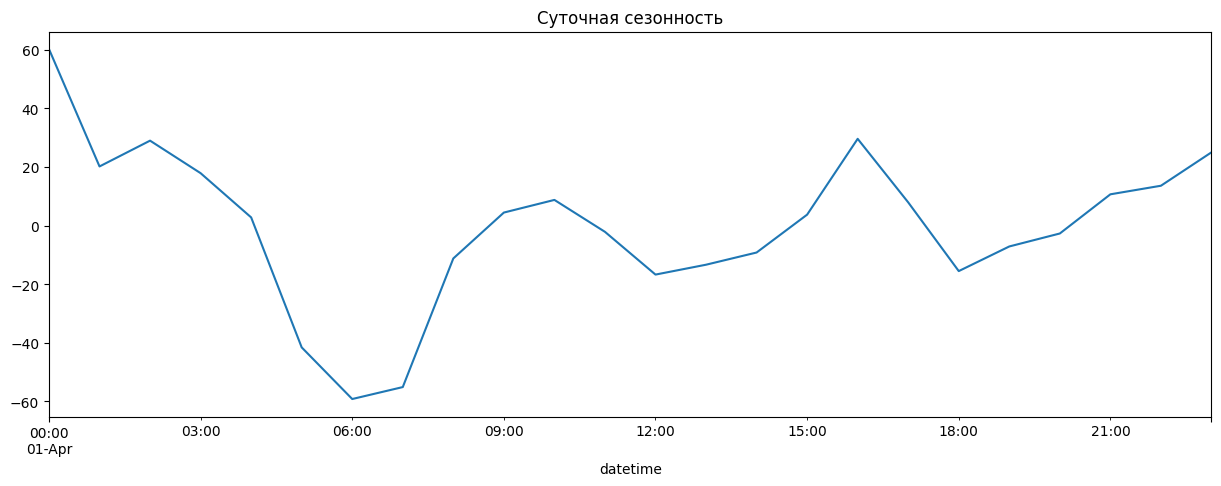

In [19]:
decomposed.seasonal['2018-04-01'].plot(figsize = (15 , 5), title = ('Суточная сезонность'));

Больше всего заказов приходится на вечерний ночной период и меньше всего на раннее утро

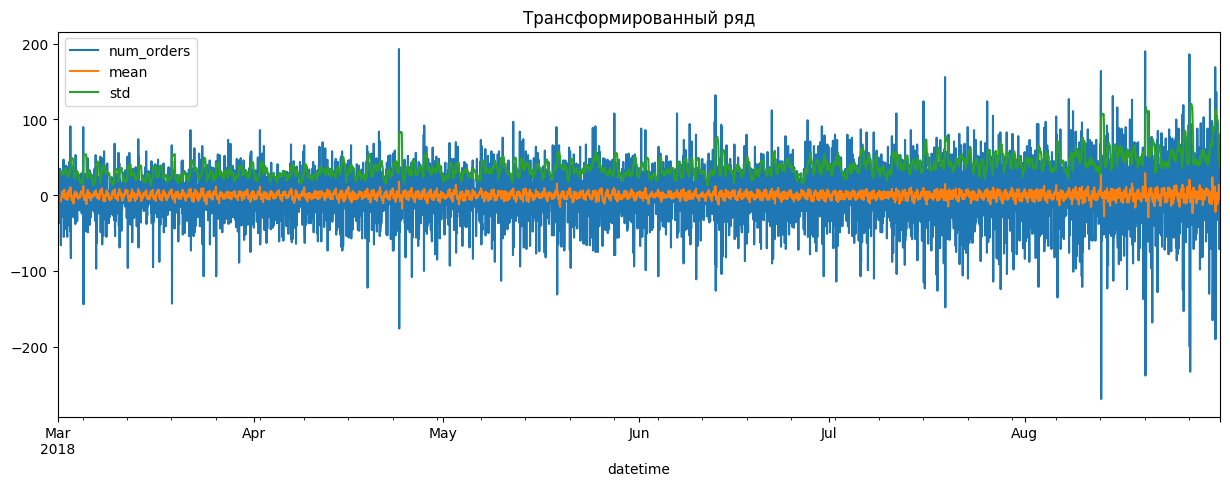

In [20]:
data_hour = data_hour - data_hour.shift()
data_hour['mean'] = data_hour['num_orders'].rolling(12).mean()
data_hour['std'] = data_hour['num_orders'].rolling(12).std()
data_hour.plot(figsize = (15 , 5), title = ('Трансформированный ряд'));

## Обучение

In [21]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [22]:
def rmse(target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

In [23]:
rmse_score = make_scorer(rmse, greater_is_better = False)

In [24]:
make_features(data_hour, 2, 24)

In [25]:
train, test = train_test_split(data_hour, shuffle = False, test_size = 0.1)
train = train.dropna()

In [26]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 01:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [27]:
features_train = train.drop(['num_orders'], axis =1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis =1)
target_test = test['num_orders']

### Линейная регрессия

In [28]:
line_model = LinearRegression()
line_model.fit(features_train, target_train)
train_pred = line_model.predict(features_train)
print("RMSE:", rmse(target_train, train_pred))

RMSE: 29.074292422047826


### CatBoost

In [29]:
cat_model = CatBoostRegressor(random_seed = 88, verbose = 1)

tscv = TimeSeriesSplit(n_splits = 2)
params = {'learning_rate': [0.01, 0.1, 0.5, 1, 2],
        'iterations': [20, 60],
        'depth': [6, 8, 10],
        }
cat_cv = GridSearchCV(cat_model, params, scoring = rmse_score, n_jobs = -1, cv = tscv, verbose = 1)

cat_cv.fit(features_train, target_train)

print(cat_cv.best_params_)
print('RMSE:', -(cat_cv.best_score_))

Fitting 2 folds for each of 30 candidates, totalling 60 fits
0:	learn: 30.8895820	total: 55.9ms	remaining: 3.3s
1:	learn: 28.0094785	total: 74.5ms	remaining: 2.16s
2:	learn: 25.1809161	total: 87.5ms	remaining: 1.66s
3:	learn: 23.6490810	total: 96.3ms	remaining: 1.35s
4:	learn: 22.7101144	total: 119ms	remaining: 1.3s
5:	learn: 22.0735158	total: 131ms	remaining: 1.18s
6:	learn: 21.2048304	total: 148ms	remaining: 1.12s
7:	learn: 20.6857584	total: 159ms	remaining: 1.03s
8:	learn: 20.2397534	total: 175ms	remaining: 993ms
9:	learn: 20.1128119	total: 187ms	remaining: 934ms
10:	learn: 19.8089309	total: 196ms	remaining: 872ms
11:	learn: 19.5193599	total: 205ms	remaining: 819ms
12:	learn: 19.3570693	total: 214ms	remaining: 774ms
13:	learn: 19.0671219	total: 235ms	remaining: 772ms
14:	learn: 18.8880263	total: 249ms	remaining: 746ms
15:	learn: 18.8316948	total: 257ms	remaining: 706ms
16:	learn: 18.6219976	total: 263ms	remaining: 666ms
17:	learn: 18.4693055	total: 281ms	remaining: 657ms
18:	learn: 

### LightGBM

In [30]:
%%time

light_model = LGBMRegressor(random_state = 88)
tscv = TimeSeriesSplit(n_splits = 2)
light_params = {'n_estimators': [10,50,100],
               'max_depth': [15,30],
               'num_leaves': [10,20,31],
               'learning_rate': [0.1]}
light_cv = GridSearchCV(light_model,
                             light_params,
                             cv = tscv,
                             scoring = 'neg_mean_squared_error',
                             n_jobs = -1,
                             verbose = False,
                             error_score = 'raise')

light_cv.fit(features_train, target_train)

print(light_cv.best_params_)
print('RMSE - ', (-light_cv.best_score_) ** 0.5)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 3949, number of used features: 7
[LightGBM] [Info] Start training from score 0.007344
{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100, 'num_leaves': 20}
RMSE -  22.849769562202336
CPU times: user 304 ms, sys: 16.5 ms, total: 321 ms
Wall time: 2.88 s


### Лес решений

In [31]:
forest_model = RandomForestRegressor(random_state = 88)
parametrs = {'max_depth' : range(2, 10, 2),
            'n_estimators' : range(5, 65, 10)}
tscv = TimeSeriesSplit(n_splits = 2)
grid = GridSearchCV(forest_model, parametrs, scoring = rmse_score, cv = tscv)
grid.fit(features_train, target_train)
best_score = grid.best_score_
print(grid.best_estimator_)
print('RMSE: ', -grid.best_score_)

RandomForestRegressor(max_depth=8, n_estimators=45, random_state=88)
RMSE:  25.429097306422257


### Дерево решений

In [32]:
tree_model = DecisionTreeRegressor(random_state = 88)
parametrs = {'max_depth' : range(1, 10, 1)}
grid = GridSearchCV(tree_model, parametrs, scoring = 'neg_mean_absolute_error', cv = 5)
grid.fit(features_train, target_train)
best_score = grid.best_score_
print(grid.best_estimator_)
print('MAE: ', -grid.best_score_)

DecisionTreeRegressor(max_depth=8, random_state=88)
MAE:  20.05683560019538


Наилучшая метрика у LGBMRegressor и CatBoostRegressor, для теста выбираем CatBoostRegressor(разница в 0.017)


## Тестирование

In [33]:
cat_model = CatBoostRegressor(random_seed = 88, learning_rate = 0.5, iterations = 60, depth = 6, verbose = False)
cat_model.fit(features_train, target_train)
cat_target_predict = cat_model.predict(features_test)
print('RMSE: ', rmse(target_test, cat_target_predict))

RMSE:  35.552110207410585


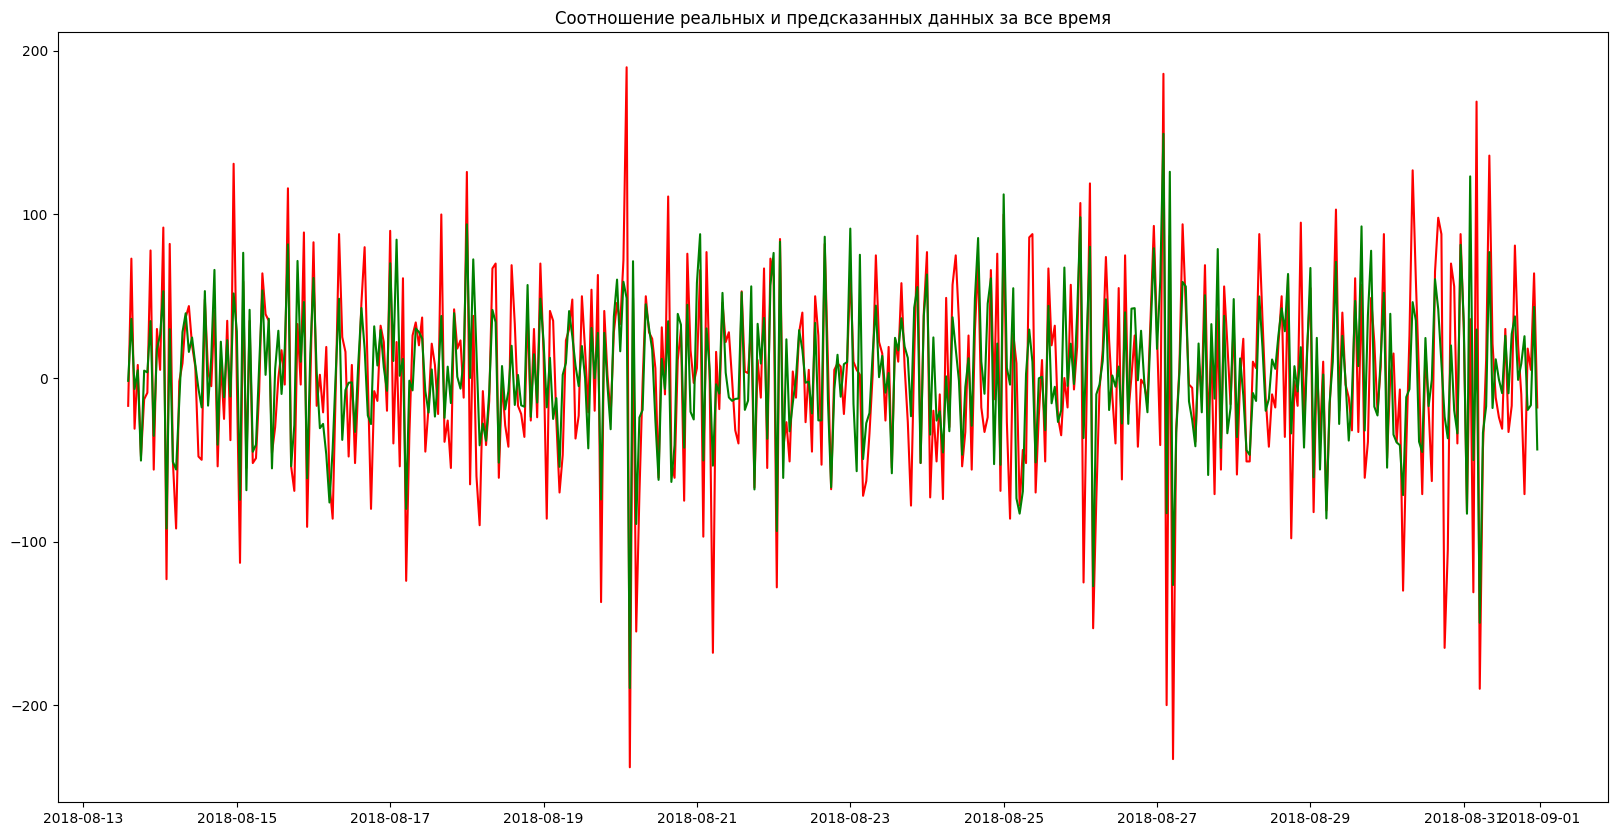

In [40]:
plt.figure(figsize = (20, 10))
plt.plot(target_test, color = 'red')
plt.plot(target_test.index, cat_target_predict, color = 'green')
plt.title('Соотношение реальных и предсказанных данных за все время');

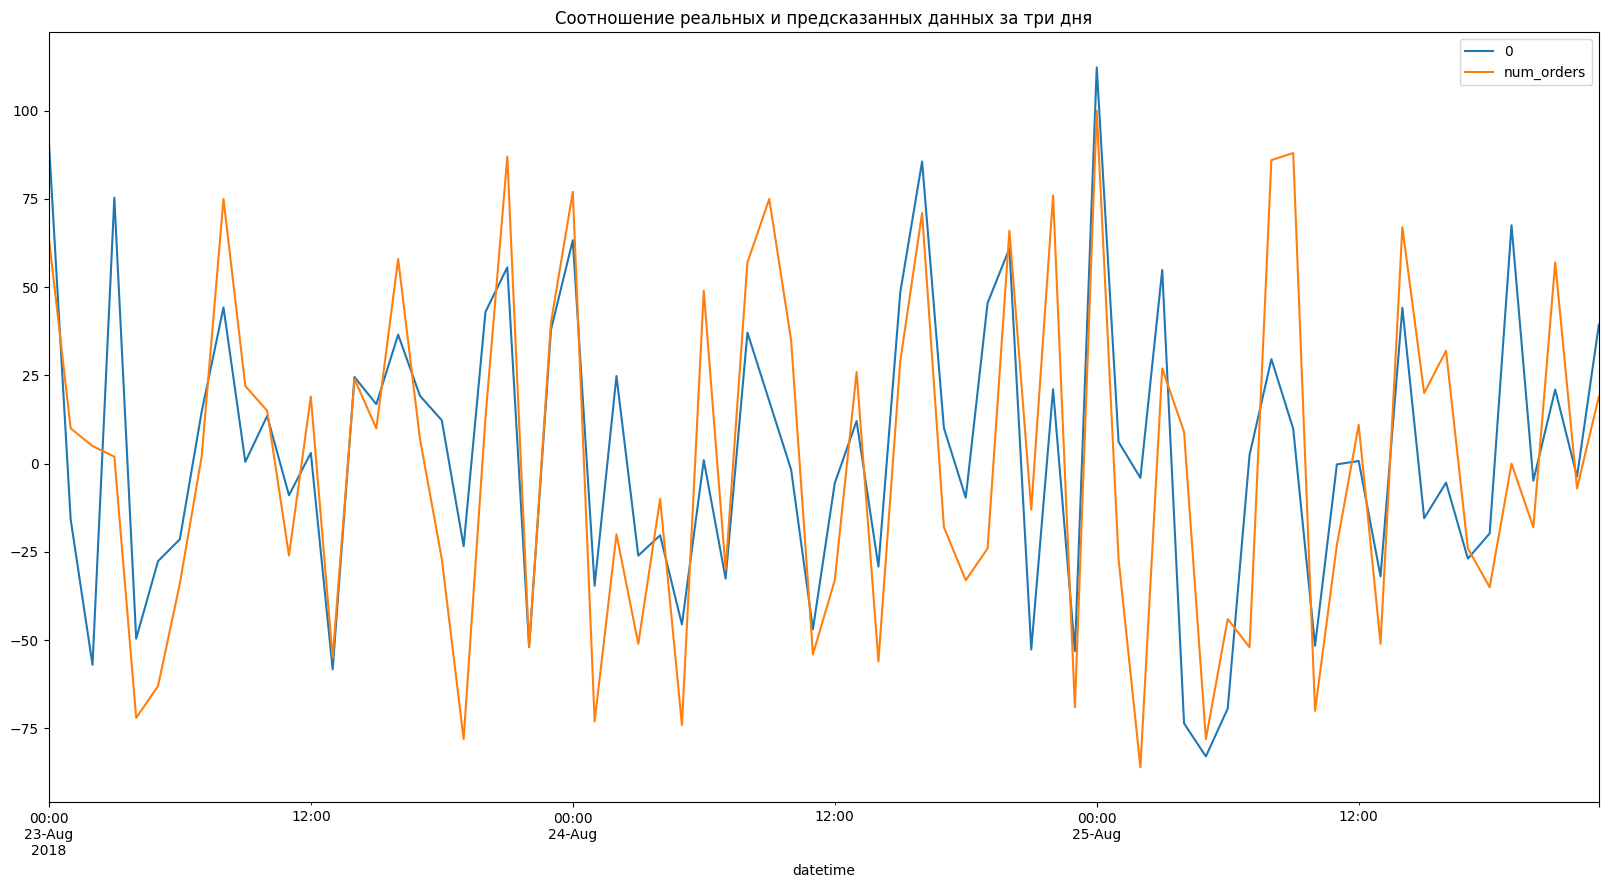

In [41]:
predictions = pd.DataFrame(data = cat_target_predict, index = target_test.index)
predictions = predictions.join(target_test, rsuffix='_right')
predictions['2018-08-23':'2018-08-25'].plot(figsize = (20, 10))
plt.legend()
plt.title('Соотношение реальных и предсказанных данных за три дня');

Судя по графикам предсказанияи и изначальные данные примерно сходятся, но предсказания более сглаженные

## Вывод

Были рассмотренны данные с марта по сентябрь по количеству заказов такси, ряд был нестационарным, к концу среднее увеличивалось.
Обучили несколько моделей, выбрали по наилучшей метрике - CatBoostRegressor, на тесте дает ошибку 35.